# Predicting Minneapolis Crimes

Michael Haugan <br>
Northwestern MSDS <br>
Spring Capstone (2020) <br>

I am using historical crime data from the city of Minneapolis (http://opendata.minneapolismn.gov/) as well as connecting other various external sources to see if I can predict crimes that will occur within the city.

Weather: https://openweathermap.org/

## EDA

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [300]:
# load in crime dataset for one year
crime19 = pd.read_csv("Police_Incidents_2019.csv")
crime182 = pd.read_csv("Police_Incidents_2018_PIMS.csv")
crime181 = pd.read_csv("Police_Incidents_2018.csv")
crime17 = pd.read_csv("Police_Incidents_2017.csv")

In [301]:
# view size
print(crime19.shape)
print(crime182.shape)
print(crime181.shape)
print(crime17.shape)

(25000, 23)
(11604, 23)
(7350, 20)
(22085, 20)


### clean column names

In [302]:
# change columns names to all match
crime19 = crime19.rename(columns={"centerLat": "Lat", "centerLong": "Long", "description": "Description", 
                                  "offense": "Offense", "precinct": "Precinct", "reportedDateTime": "ReportedDateTime",
                                 "neighborhood": "Neighborhood"})
crime182 = crime182.rename(columns={"centerLat": "Lat", "centerLong": "Long", "description": "Description", 
                                  "offense": "Offense", "precinct": "Precinct", "reportedDateTime": "ReportedDateTime",
                                 "neighborhood": "Neighborhood"})
crime181 = crime181.rename(columns={"ReportedDate": "ReportedDateTime"})
crime17 = crime17.rename(columns={"ReportedDate": "ReportedDateTime"})

### subset dataframe to only needed columns

In [303]:
# keep only necessary columns from df's
c19 = crime19[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c182 = crime182[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c181 = crime181[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c17 = crime17[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]

### concatenate together, sort and clean

In [304]:
# concatenate df's together and sort by date
frames = [c19, c182, c181, c17]
df = pd.concat(frames)
df = df.sort_values(['ReportedDateTime'])

In [305]:
# change timestamp to date char type
df['ReportedDateTime'] = pd.to_datetime(df['ReportedDateTime'])

In [306]:
# strip date and time and hour from timestamp
df['Time'] = df['ReportedDateTime'].apply( lambda d : d.time() )
df['Date'] = df['ReportedDateTime'].apply( lambda d : d.date() )
df['Hour'] = df['ReportedDateTime'].apply( lambda d : d.hour)

# make date a date char type
df['Date'] = pd.to_datetime(df['Date'])

# remove whitespace from Offense and Precinct
df['Offense'] = df['Offense'].str.strip()

# change AUTOTH to GTA to make more clear
df['Offense']=df['Offense'].apply(lambda x:(x.replace('AUTOTH','GTA')))
# combine other autothefts into one as they are all similar
df['Offense']=df['Offense'].apply(lambda x:(x.replace('MVTHFT', 'TFMV').replace('TMVP', 'TFMV')))

# remove punctuation from neighborhood column
df['Neighborhood'] = df['Neighborhood'].str.replace(r"[\"\',]", '')

# remove na's (exist in precinct and neighborhood)
df = df.dropna()

# remove UI, 18 and 99 from precinct
df = df[df.Precinct != 'UI    ']
df = df[df.Precinct != 18]
df = df[df.Precinct != 99]

# convert precinct column to int
df['Precinct'] = df['Precinct'].astype(int)

df.head()

,ReportedDateTime,Lat,Long,Neighborhood,Precinct,Offense,Description,Time,Date,Hour
0,2017-01-01 00:53:00+00:00,44.899175,-93.219132,MORRIS PARK,3,ASLT2,Asslt W/dngrs Weapon,00:53:00,2017-01-01,0
1,2017-01-01 02:10:00+00:00,44.984470,-93.298200,HARRISON,4,ASLT2,Asslt W/dngrs Weapon,02:10:00,2017-01-01,2
2,2017-01-01 02:32:00+00:00,44.980982,-93.235388,MARCY HOLMES,2,THEFT,Other Theft,02:32:00,2017-01-01,2
3,2017-01-01 02:42:00+00:00,44.988726,-93.232040,COMO,2,GTA,Motor Vehicle Theft,02:42:00,2017-01-01,2
5,2017-01-01 04:04:00+00:00,44.942137,-93.248657,POWDERHORN PARK,3,TFMV,Theft From Motr Vehc,04:04:00,2017-01-01,4


In [307]:
# add in day of week based on date
df['DoW'] = df['ReportedDateTime'].dt.day_name()

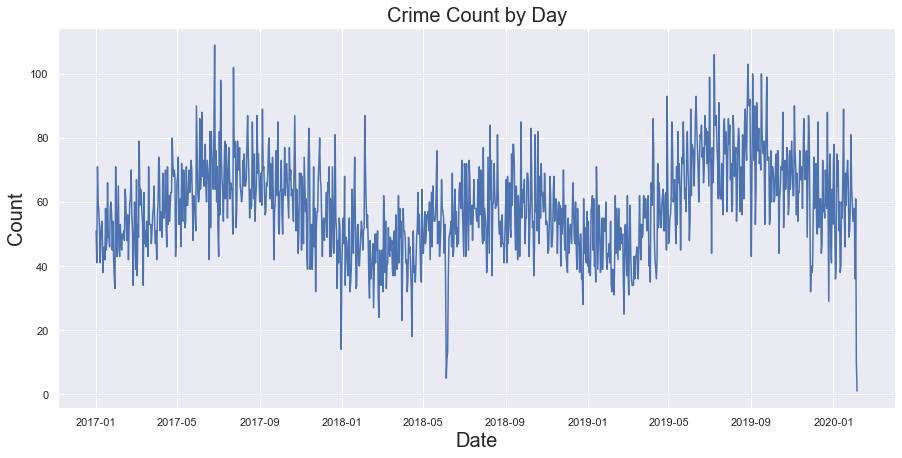

In [134]:
# group crimes by date and plot
import seaborn as sns

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
df_date = df.groupby('Date').count()
df_date.reset_index(inplace=True)
s = sns.lineplot(x="Date", y="Offense", data=df_date)
s.set_xlabel('Date', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime Count by Day', fontsize=20)
s.tick_params(labelsize=11)
plt.show()

There is definitely some seasonality involved with crime. We will see this better when we look at crime by temperature, but an educated guess is that crime increases as the weather gets warmer out (this makes a huge difference in Minnesota!)

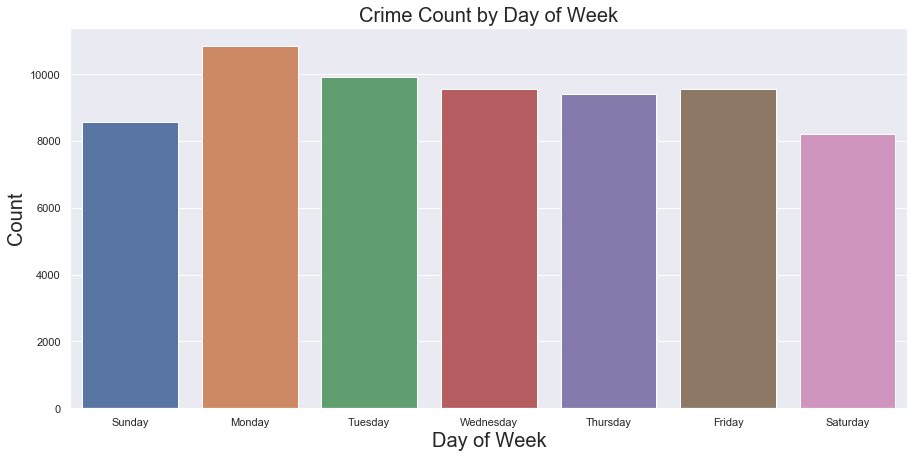

In [137]:
# group crimes by day of week and plot

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x="DoW", data=df)
s.set_xlabel('Day of Week', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime Count by Day of Week', fontsize=20)
s.tick_params(labelsize=11)
plt.show()

Somewhat suprisingly (I guess?) Monday has the highest total crime, followed by Tuesday and then Friday.

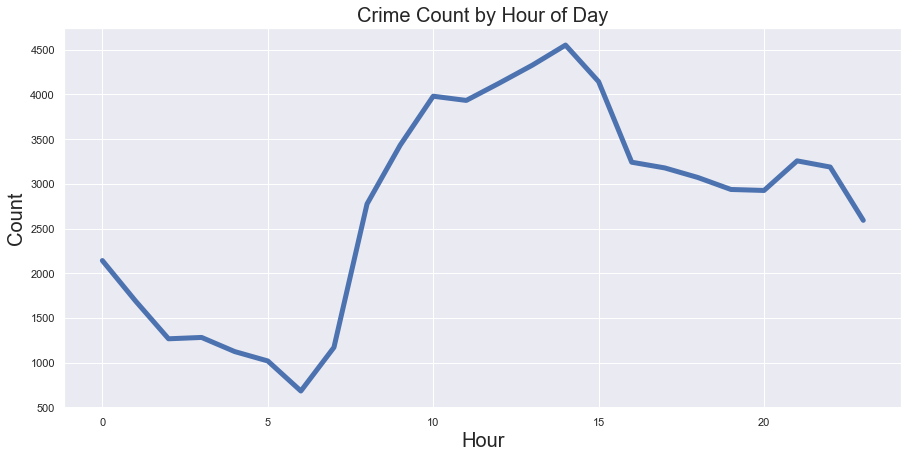

In [177]:
# group crimes by time of day and plot
import seaborn as sns

# set plot specs
sns.set(rc={'figure.figsize':(15, 7), "lines.linewidth": 5})

# plot
df_time = df.groupby('Hour').count()
df_time.reset_index(inplace=True)
s = sns.lineplot(x="Hour", y="Offense", data=df_time)
s.set_xlabel('Hour', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime Count by Hour of Day', fontsize=20)
s.tick_params(labelsize=11)
plt.show()

Crime spikes the highest between the hours of 7am through 3pm and then slowly tapers. It then spikes slightly again around 8pm and 10pm. Crime is lowest between the very early morning hours of 12am through 6am.

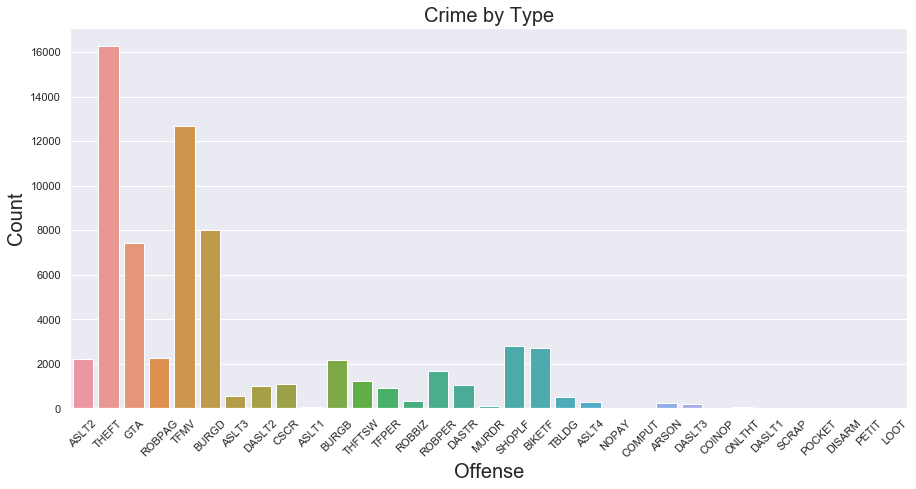

In [210]:
# group crimes by type of crime and plot

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x="Offense", data=df)
s.set_xlabel('Offense', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime by Type', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()

Theft (other), theft from motor vehicles, burglary and grand theft auto are far and away the most common crime types in Minneapolis (apparently a lot of kleptomaniacs).

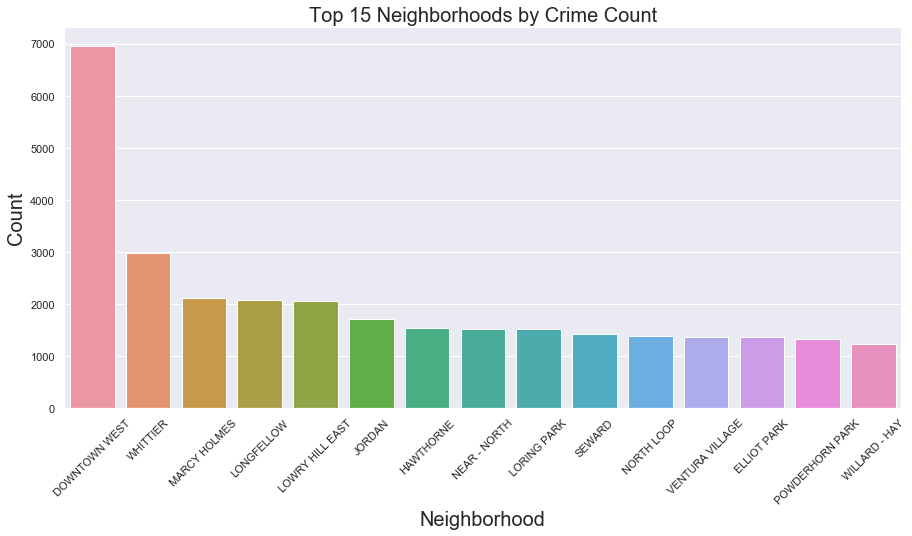

In [239]:
# group crimes by neighborhood and plot

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x="Neighborhood", data=df, order=df.Neighborhood.value_counts().iloc[:15].index)
s.set_xlabel('Neighborhood', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Top 15 Neighborhoods by Crime Count', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()

Downtown west is far and away the least safe neighborhood followed by Whittier and Marcy Holmes.

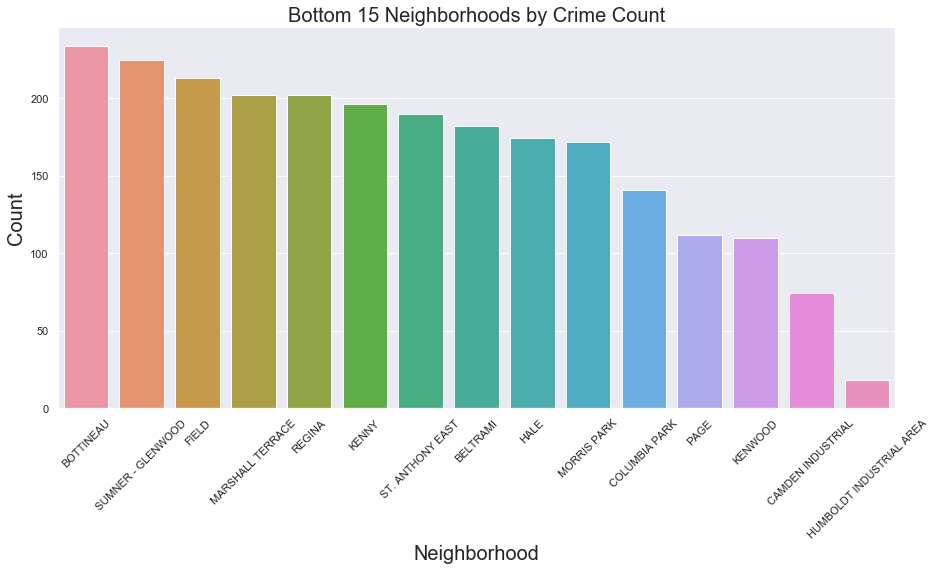

In [242]:
# group crimes by neighborhood and plot

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x="Neighborhood", data=df, order=df.Neighborhood.value_counts().iloc[-15:].index)
s.set_xlabel('Neighborhood', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Bottom 15 Neighborhoods by Crime Count', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()

These are our safest neighborhood's by crime counts.

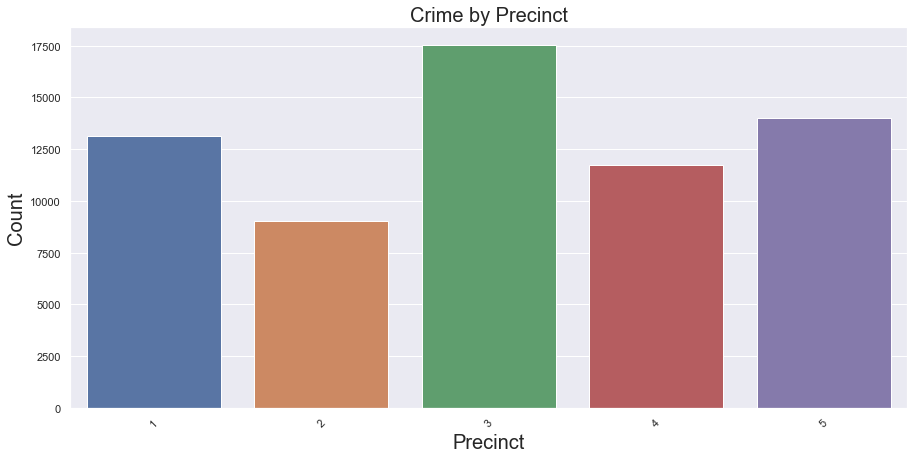

In [310]:
# group crimes by precinct and plot

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x="Precinct", data=df)
s.set_xlabel('Precinct', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime by Precinct', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()

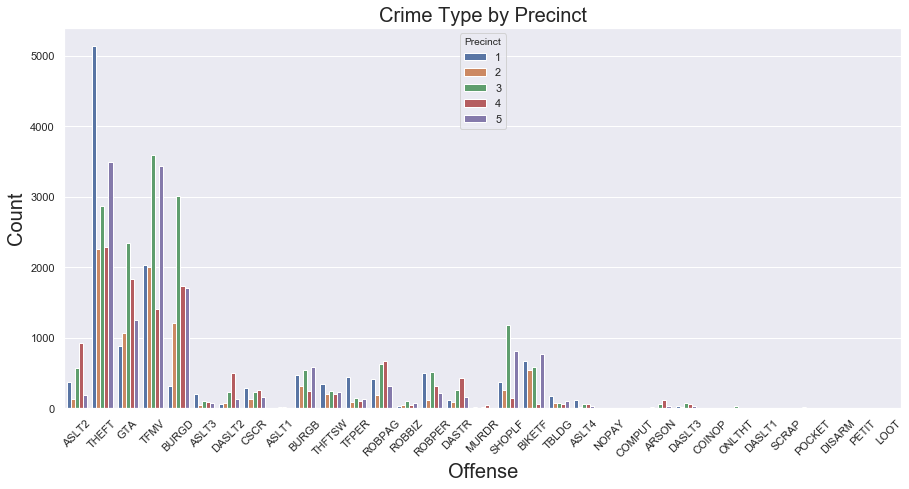

In [313]:

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x="Offense", data=df, hue="Precinct")
s.set_xlabel('Offense', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime Type by Precinct', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()